<a href="https://colab.research.google.com/github/kalepravinkumars/2019-CS109A/blob/segmentation_edgedetection/Manufacturing_Intelligence_ITR_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import necessery liberis into the session
import os
from cv2 import imread,imshow,cvtColor,COLOR_BGR2RGB,COLOR_BGR2GRAY,COLOR_RGB2GRAY,resize
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) #print no of GPU device

Num GPUs Available:  1


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
#directiry name
dir512x512='/content/drive/MyDrive/Colab Notebooks/CastingProductImageData/casting_512x512/casting_512x512'

In [ ]:
def edge_det(image):
  image=image.reshape(512,512)
  # Apply Canny edge detection
  edges = cv2.Canny(image, 250, 50)  # Adjust the threshold values as per your preference

  # Create a blank image with white background
  height, width = image.shape[:2]
  blank_image = np.zeros((height, width, 1), np.uint8)
  blank_image.fill(255)

  # Set the edges on the blank image to black
  blank_image[edges != 0] = (0)

  return blank_image

In [ ]:
df_stats_def=pd.DataFrame()
# Get a list of all the files in the directory
extra='/def_front/'
directory=dir512x512+extra
files = os.listdir(directory)

img_edgedata=[]
passfail=[]

# Filter the list to only include JPEG files
jpeg_files = [f for f in files if f.endswith('.jpeg')]
df_stats_def['filename']=jpeg_files


img_flat_data=np.array([edge_det(cvtColor(imread(dir512x512+extra+f), COLOR_BGR2GRAY)).flatten() for f in jpeg_files])
df_stats_def['mean']=[np.mean(edge_det(cvtColor(imread(dir512x512+extra+f), COLOR_BGR2GRAY)).flatten()) for f in jpeg_files]
df_f=pd.DataFrame(img_flat_data)


# Get a list of all the files in the directory
extra='/ok_front/'
directory=dir512x512+extra
files = os.listdir(directory)
df_stats_ok=pd.DataFrame()

# Filter the list to only include JPEG files
jpeg_files = [f for f in files if f.endswith('.jpeg')]
df_stats_ok['filename']=jpeg_files


img_flat_data=np.array([edge_det(cvtColor(imread(dir512x512+extra+f), COLOR_BGR2GRAY)).flatten() for f in jpeg_files])
df_stats_ok['mean']=[np.mean(edge_det(cvtColor(imread(dir512x512+extra+f), COLOR_BGR2GRAY)).flatten()) for f in jpeg_files]
df_p=pd.DataFrame(img_flat_data)

In [ ]:
df_p.head()

,0,1,2,3,4,5,6,7,8,9,...,262134,262135,262136,262137,262138,262139,262140,262141,262142,262143
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [ ]:
df_stats_ok.head()

,filename,mean
0,cast_ok_0_1021.jpeg,247.548752
1,cast_ok_0_2060.jpeg,248.745232
2,cast_ok_0_1817.jpeg,247.726765
3,cast_ok_0_1573.jpeg,247.679100
4,cast_ok_0_1963.jpeg,248.956318


In [ ]:
df_stats_def.head()

,filename,mean
0,cast_def_0_100.jpeg,247.482605
1,cast_def_0_1053.jpeg,248.928108
2,cast_def_0_102.jpeg,248.329868
3,cast_def_0_1046.jpeg,247.073078
4,cast_def_0_1015.jpeg,247.740383


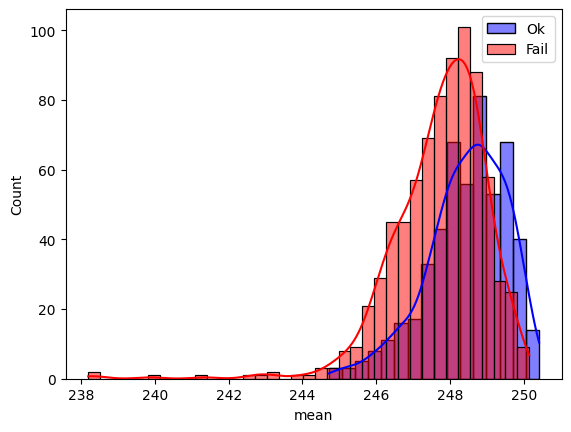

In [ ]:
sns.histplot(df_stats_ok['mean'], label='Ok', color='blue', alpha=0.5, kde=True)
sns.histplot(df_stats_def['mean'], label='Fail', color='red', alpha=0.5, kde=True)
# Add legend
plt.legend()

In [ ]:
#df_f=df_f[:300]
df_f.shape

(781, 262144)

In [ ]:
#df_p=df_p[:300]
df_p.shape

(519, 262144)

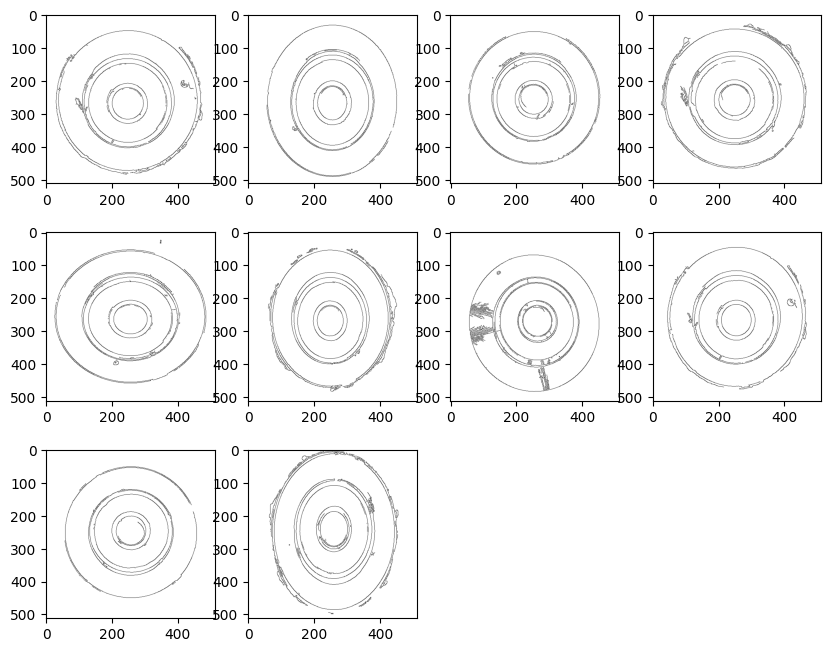

In [ ]:
#Fail or NoOkey or defective parts
plt.figure(figsize=(10,8))
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.imshow(df_f.iloc[i:i+1,:].values.reshape(512,512,1),cmap='gray')

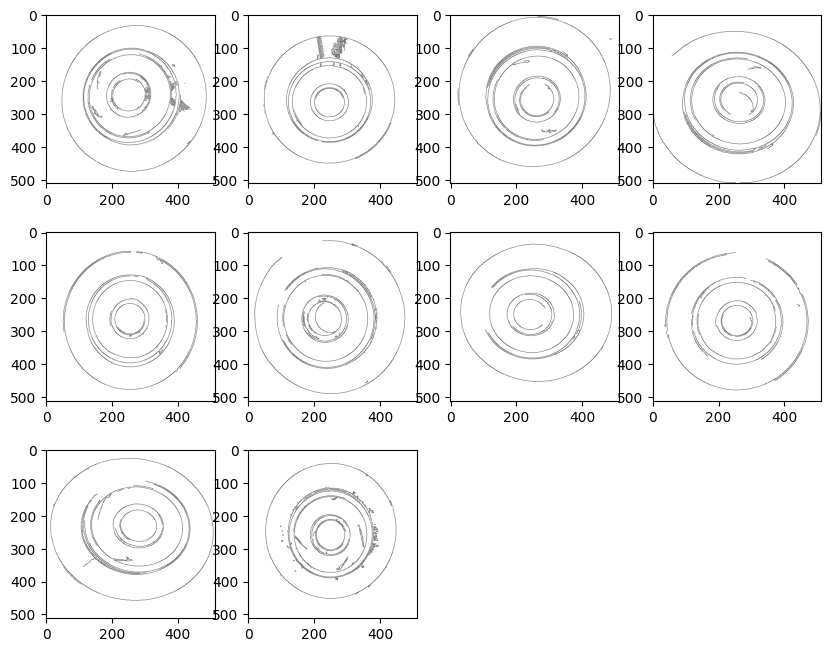

In [ ]:
#Pass or Okey or without defect parts
plt.figure(figsize=(10,8))
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.imshow(df_p.iloc[i:i+1,:].values.reshape(512,512,1), cmap='gray')

In [ ]:
# Define Y or resonse
# 0 means Fail, and 1 mean Pass

df_f['Y']=0
df_p['Y']=1

In [ ]:
#Combine two dataframe
df=pd.concat([df_f,df_p], axis=0)
df.index=range(df.shape[0])
df.shape

(1300, 262145)

In [ ]:
#importing the Liberiers to create model
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Convolution2D,MaxPool2D,Flatten
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
X=df.drop(labels='Y', axis=1)

X=X.values.reshape(X.shape[0],512,512,1)
#X=np.expand_dims(X, axis=-1)

Y=df[['Y']].values

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
Xtrain, Xtest, ytrain, ytest=train_test_split(X,Y,test_size=0.30,random_state=101 )

Model 2

In [ ]:
model=tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=16,kernel_size=(3,3), activation='relu', input_shape=(512,512,1)))
model.add(tf.keras.layers.MaxPool2D(
    (2,2)))

model.add(tf.keras.layers.Conv2D(
    filters=32,kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(
    (2,2)))

model.add(tf.keras.layers.Conv2D(
    filters=64,kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(
    (2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))

model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_accuracy', patience=5, mode='min')

In [ ]:
model.fit(Xtrain,ytrain, epochs=20, batch_size=64, validation_data=(Xtest,ytest), callbacks=[early_stopping])

Epoch 1/20
15/15 [==============================] - 19s 311ms/step - loss: 268.4308 - accuracy: 0.5132 - val_loss: 0.5893 - val_accuracy: 0.7026
Epoch 2/20
15/15 [==============================] - 3s 198ms/step - loss: 0.5870 - accuracy: 0.7022 - val_loss: 0.5143 - val_accuracy: 0.7513
Epoch 3/20
15/15 [==============================] - 3s 198ms/step - loss: 0.4613 - accuracy: 0.7846 - val_loss: 0.5635 - val_accuracy: 0.6718
Epoch 4/20
15/15 [==============================] - 3s 199ms/step - loss: 0.6851 - accuracy: 0.7088 - val_loss: 0.6906 - val_accuracy: 0.5308
Epoch 5/20
15/15 [==============================] - 3s 199ms/step - loss: 0.6563 - accuracy: 0.7011 - val_loss: 0.7138 - val_accuracy: 0.6103
Epoch 6/20
15/15 [==============================] - 3s 195ms/step - loss: 0.4420 - accuracy: 0.7868 - val_loss: 0.5179 - val_accuracy: 0.7462
Epoch 7/20
15/15 [==============================] - 3s 196ms/step - loss: 0.2959 - accuracy: 0.8802 - val_loss: 0.4754 - val_accuracy: 0.7744
Epo

In [ ]:
ytest_pred=model.predict(Xtest)

13/13 [==============================] - 1s 27ms/step


In [ ]:
for i in range(len(ytest_pred)):
    if ytest_pred[i]>0.5:
        ytest_pred[i]=1
    else:
        ytest_pred[i]=0

In [ ]:
print(confusion_matrix(ytest,ytest_pred))
print(classification_report(ytest,ytest_pred))

[[213  37]
 [ 38 102]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       250
           1       0.73      0.73      0.73       140

    accuracy                           0.81       390
   macro avg       0.79      0.79      0.79       390
weighted avg       0.81      0.81      0.81       390





1. Thresholding
2. region growing
3. Edge Detection
4. Contour Detection
5. Clustering
6. Graph Based Segmentation
7. GrabCut
8. Watershead
9. Deep leanring based leanring approach (FCNs, U-Net)

Thresholding: Thresholding is often used when there is a clear contrast between the objects of interest and the background in terms of pixel intensity. It works well when the objects can be separated based on a specific threshold value.

Region Growing: Region growing is suitable when there are clear regions or objects in the image with similar characteristics, such as intensity or texture. It works well when the objects have relatively uniform properties and are distinct from their surroundings.

Edge Detection: Edge detection is useful when the boundaries or edges of objects are important for segmentation. It is commonly used when the objects have well-defined edges, and separating them based on these edges provides meaningful segmentation.

Contour Detection: Contour detection is appropriate when the shape or boundary of objects is crucial for segmentation. It works well when the objects have distinct boundaries that can be traced as contours.

Clustering: Clustering techniques are effective when the objects or regions in the image can be grouped based on similarity in color, intensity, or feature space. It is useful when there are multiple objects with different characteristics that need to be separated.

Graph-Based Segmentation: Graph-based methods are suitable when the relationships between neighboring pixels play a vital role in defining the segments. They work well when the image can be represented as a graph, and segmenting based on graph cuts yields meaningful results.

GrabCut: GrabCut is often used for object segmentation when there is a rough estimate or bounding box of the object available. It works well when the object to be segmented is relatively well-defined and can be localized within the image.

Watershed Transform: The watershed transform is useful when there are distinct regions or objects with intensity differences that can be represented as basins and ridges. It is commonly used for segmenting objects in medical imaging or scenes with clearly separated regions.

Deep Learning-Based Segmentation: Deep learning-based segmentation, particularly using CNN architectures like FCNs and U-Net, is powerful when there is a large dataset available for training and when the segmentation task requires complex feature extraction. It works well for semantic segmentation tasks where pixel-level segmentation is needed.

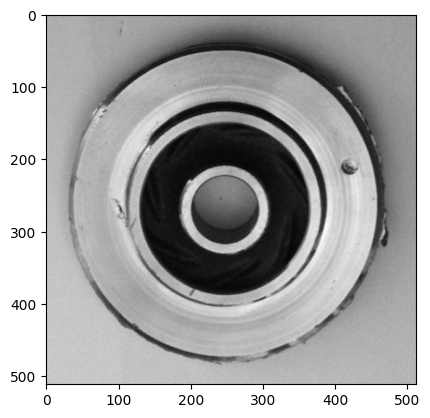

In [ ]:
img=df.iloc[0:1,:df.shape[1]-1].values
img=img.reshape(512,512)
plt.imshow(img, cmap='gray')

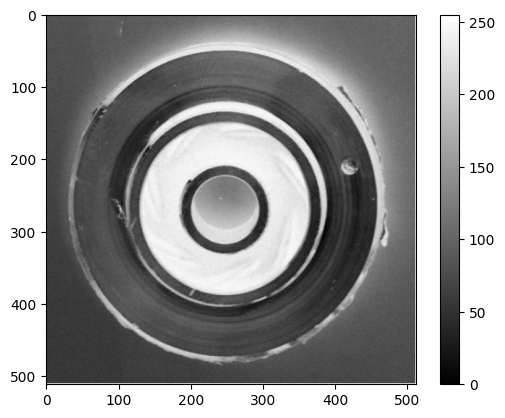

In [ ]:
img=df.iloc[0:1,:df.shape[1]-1].values
img=img.reshape(512,512)


#Apply threshoulding to obtain a binery image
_, binary = cv2.threshold(img,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(binary, cmap='gray')


# Find contours in the binary image
contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a blank image for drawing contours
#contour_image = np.ones_like(img)*255
contour_image = img.copy()

# Draw contours on the blank image
cv2.drawContours(contour_image, contours, -1, (0, 0, 0), 1)

# Invert the image (optional)
contour_image = 255 - contour_image

# Display the original image and the contour image
#plt.imshow(img)
plt.imshow(contour_image, cmap='gray')
plt.colorbar()

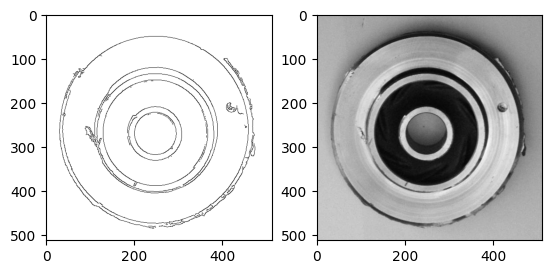

In [ ]:
img=df.iloc[0:1,:df.shape[1]-1].values
img=img.reshape(512,512)

# Apply Canny edge detection
edges = cv2.Canny(img, 250, 50)  # Adjust the threshold values as per your preference

# Create a blank image with white background
height, width = img.shape[:2]
blank_image = np.zeros((height, width, 3), np.uint8)
blank_image.fill(255)

# Set the edges on the blank image to black
blank_image[edges != 0] = (0, 0, 0)

# Display the edge image
plt.subplot(1,2,1)
plt.imshow(blank_image,cmap='gray')

plt.subplot(1,2,2)
plt.imshow(img,cmap='gray')



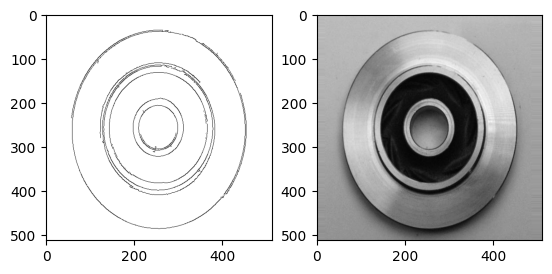

In [ ]:

img=df.iloc[df.shape[0]-1:df.shape[0],:df.shape[1]-1].values
img=img.reshape(512,512)

# Apply Canny edge detection
edges = cv2.Canny(img, 250, 50)  # Adjust the threshold values as per your preference

# Create a blank image with white background
height, width = img.shape[:2]
blank_image = np.zeros((height, width, 3), np.uint8)
blank_image.fill(255)

# Set the edges on the blank image to black
blank_image[edges != 0] = (0, 0, 0)

# Display the edge image
plt.subplot(1,2,1)
plt.imshow(blank_image,cmap='gray')

plt.subplot(1,2,2)
plt.imshow(img,cmap='gray')


In [ ]:
def edge_det(image):
  # Apply Canny edge detection
  edges = cv2.Canny(image, 250, 50)  # Adjust the threshold values as per your preference

  # Create a blank image with white background
  height, width = img.shape[:2]
  blank_image = np.zeros((height, width, 1), np.uint8)
  blank_image.fill(255)

  # Set the edges on the blank image to black
  blank_image[edges != 0] = (0)

  return blank_image

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,262135,262136,262137,262138,262139,262140,262141,262142,262143,Y
0,175,175,174,171,168,167,168,170,168,169,...,181,182,184,185,184,182,182,183,184,0
1,139,139,138,138,137,137,136,136,138,138,...,158,156,156,156,156,156,156,156,156,0
2,141,142,142,140,139,139,141,144,145,134,...,167,168,167,166,165,164,163,164,164,0
3,161,162,164,165,166,165,165,164,162,162,...,182,181,180,179,178,178,178,178,178,0
4,140,142,144,144,142,141,141,142,145,142,...,159,158,156,154,155,158,160,162,162,0


In [ ]:
img_edgedata=[]
passfail=[]
for i in range(df.shape[0]):
  img=df.iloc[i:i+1,:df.shape[1]-1].values
  img=img.reshape(512,512)
  new_img=edge_det(img)
  img_edgedata.append(new_img.flatten())
  passfail.append(df['Y'][i])

In [ ]:
df_edge=pd.DataFrame(img_edgedata)
df_edge['Y']=passfail

df_edge.head()

In [ ]:
df_edge.shape

# segmentation to reduce the overlap area

In [ ]:
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image

# Load the pre-trained VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))


In [ ]:

# Get a list of all the files in the directory
extra='\def_front\\'
extra='\ok_front\\'

for item in jpeg_files:
    image = cv2.imread(imread(dir512x512+extra+f))
    image = cv2.resize(image,(224,224))
    image = np.expand_dims(image, axis=0)
    
    image = preprocess_input(image)
    
    #
    # Extract features using VGG16
    features = vgg_model.predict(image)
    
    # Flatten the features
    flatten_features = features.flatten()
    
    # Print the shape of the flattened features
    print("Flattened Features Shape:", flatten_features.shape)

In [ ]:
a=df_p.iloc[0:1].values.reshape(512,512)
a=cv2.resize(a,(224,224))
print(a)

In [ ]:
with tf.device('/GPU:0'):
    model_1=Sequential([
    Convolution2D(filters=16,kernel_size=(3,3),input_shape=(256,256,1)),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(units=256,activation='relu'),
    Dense(units=128,activation='relu'),
    Dense(units=64,activation='relu'),
    Dense(units=32,activation='relu'),
    Dense(units=1, activation='sigmoid')    
    ])
    
    
    model_1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    
    batch_size=16
    dataset = tf.data.Dataset.from_tensor_slices((Xtrain, ytrain))
    dataset = dataset.batch(batch_size)
    
    history_1=model_1.fit(dataset, epochs=10, validation_data=(Xtest,ytest))

In [ ]:
!nvidia-smi

In [ ]:
model_1=Sequential([
    Convolution2D(filters=16,kernel_size=(3,3),input_shape=(256,256,1),activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Convolution2D(filters=32,kernel_size=(3,3),input_shape=(256,256,1),activation='relu'),
    Flatten(),
#    Dense(units=128,activation='relu'),
#    Dense(units=64,activation='relu'),
    Dense(units=32,activation='relu'),
    Dense(units=1, activation='sigmoid')    
])


model_1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

batch_size=8
dataset = tf.data.Dataset.from_tensor_slices((Xtrain, ytrain))
dataset = dataset.batch(batch_size)

history_1=model_1.fit(dataset, epochs=10,validation_data=(Xtest,ytest))

In [ ]:
# Evaluate the model on test dataset
y_pred_train = model_1.predict(Xtrain)
y_pred_test = model_1.predict(Xtest)

#Get the predicted value in between 0 & 1
y_pred_train=(y_pred_train>=0.5).astype(int)
y_pred_test =(y_pred_test>=0.5).astype(int)

In [ ]:
# Generate classification report and confusion metrics to evaluate model: Test dataset
class_erport=classification_report(ytest,y_pred_test)
print('class_erport:--------------------')
print(class_erport)

conf_matrix=confusion_matrix(ytest,y_pred_test)
print('conf_matrix:--------------------')
print(conf_matrix)

plt.figure(figsize=(5,3))
target_names=[0,1]
plt.imshow(conf_matrix, cmap='binary', interpolation='None')
plt.xticks(range(len(target_names)), target_names)
plt.yticks(range(len(target_names)), target_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()